In [1]:
!nvidia-smi

Tue Apr  8 13:06:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 29.5 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Note: you may need to restart the kernel to use updated packages.


# Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, DistributedSampler
import torch.nn.functional as F
#from torch.distributions import Categorical

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp

from torch.cuda.amp import GradScaler, autocast

from PIL import Image
from skimage.color import rgb2lab, lab2rgb
from sklearn.metrics import roc_auc_score

from pathlib import Path

import time

import wandb

torch.backends.cuda.matmul.allow_tf32 = True

In [4]:
data_set_root='/kaggle/input/coco-2017-dataset/coco2017'
train_set ='train2017'
validation_set ='val2017'
test_set = 'test2017'

train_path = os.path.join(data_set_root, train_set)

val_path = os.path.join(data_set_root, validation_set)

test_path = os.path.join(data_set_root, test_set)

In [5]:
train_image_path = list(Path(train_path).rglob("*.*"))
val_image_path = list(Path(val_path).rglob("*.*"))
test_image_path = list(Path(test_path).rglob("*.*"))

print(len(train_image_path), len(val_image_path), len(test_image_path))

118287 5000 40670


(224, 224, 3)

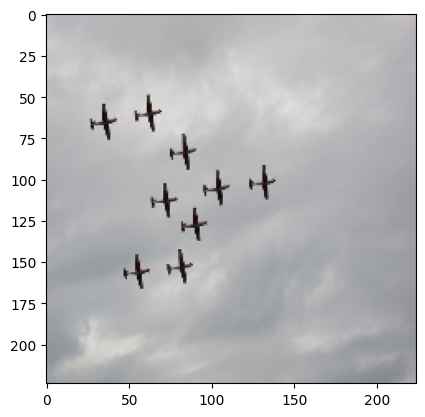

In [6]:
img = cv2.imread(train_image_path[1])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

# Set up parallel

In [7]:
def setup(rank, world_size):
    """ Initialize process group for DDP """
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank) # Ensure each process uses the correct GPU
    device = torch.device(f'cuda:{rank}')

    return device

def cleanup():
    """ Destroy process group when training is complete """
    dist.destroy_process_group()

# Parameters

In [8]:
image_size = 224

batch_size = 64

# Data Processing

In [9]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, Size=(224, 224), transform=None):
        self.paths = paths
        self.height, self.width = Size
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = img.resize((self.height, self.width), Image.BICUBIC)
        img = np.array(img)  # Convert PIL to NumPy (Albumentations requires NumPy)

        # Apply Albumentations transform if provided
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed["image"]

        # If img is in (C, H, W) format, convert to (H, W, C)
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)

        # Convert RGB → LAB
        img_lab = rgb2lab(img).astype("float32")  # (H, W, 3)

        # Extract L and ab channels
        L = img_lab[:, :, 0] 
        ab = img_lab[:, :, 1:]

        # Convert to PyTorch tensors
        L = torch.tensor(L, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
        ab = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1)  # (2, H, W)

        return {'L': L, 'ab': ab}

In [10]:
transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma (gamma_limit=(70, 130), p=0.2),
    ToTensorV2(),
])

In [33]:
def make_dataloaders(rank, world_size, batch_size=16, n_workers=0, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=rank, shuffle=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [12]:
#train_loader = make_dataloaders(batch_size = batch_size, paths=train_image_path, transform = transform)

#val_loader = make_dataloaders(batch_size = batch_size, paths=val_image_path)

In [13]:
#data = next(iter(train_loader))
#Ls, abs_ = data['L'], data['ab']
#print(Ls.shape, abs_.shape)
#print(len(train_loader), len(val_loader))

# Model

In [14]:
class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm   # Normalize L to [-0.5, 0.5]

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm    # Normalize ab to [-1, 1]

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

In [15]:
class ColorizationNet(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ColorizationNet, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

In [16]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [17]:
def create_model(rank):
    model = ColorizationNet()
    model.apply(init_weights)
    model.to(rank)  # Move model to GPU
    model = DDP(model, device_ids=[rank])  # Wrap with DDP
    return model

In [18]:
#model = create_model(rank)

In [19]:
#summary(model, (3, 256, 256))

# Hyperparameters

In [20]:
learning_rate = 1e-3

epochs = 160

model_path = '/kaggle/working/model.pth'

# Set up

In [21]:
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#scaler = torch.cuda.amp.GradScaler()

#loss_fn = nn.CrossEntropyLoss(reduction="none")


In [22]:
PROJECT = "Colorizing"
RESUME = "allow"
WANDB_KEY = "d9d14819dddd8a35a353b5c0b087e0f60d717140"

In [23]:
wandb.login(
    key = WANDB_KEY,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tr-hoanganh1124 (tr-hoanganh1124-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
# wandb.init(
#     project=PROJECT,
#     resume=RESUME,
#     name="init_colorize",
#     config={
#         "learning_rate": learning_rate,
#         "epochs": epochs,
#         "batch_size": batch_size,
#     },
# )
# wandb.watch(model)

# Train

In [25]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)

In [26]:
# Early stopping parameters
patience = 15  # Number of epochs to wait for improvement

In [27]:
from torch.multiprocessing import Manager

manager = Manager()
shared_dict = manager.dict({"learning_rate": learning_rate, 
                           "epochs": epochs,
                           "model_path" : model_path,
                           })  # Shared across ranks

# mp.spawn(train_fn, args=(shared_dict,), nprocs=2)

In [28]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Early stopping to terminate training when validation loss stops improving.

        Args:
            patience (int): Number of epochs to wait before stopping after no improvement.
            min_delta (float): Minimum change in the monitored value to be considered as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        """
        Call this function at the end of each validation step.

        Args:
            val_loss (float): Current epoch's validation loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increase counter if no improvement

        return self.counter >= self.patience  # Stop training if patience is exceeded


In [39]:
# Training function
def train(rank, world_size):
    #print(f"Process {rank} started")  # Debugging line
    device = setup(rank, world_size)

    # Dataset & DataLoader (Ensure correct sampler for DDP)
    train_loader = make_dataloaders(rank, world_size, batch_size=batch_size, n_workers=4,
                                    paths=train_image_path, transform=transform)
    val_loader = make_dataloaders(rank, world_size, batch_size = batch_size, n_workers=4, paths=val_image_path)

    # Model & Optimizer
    #torch.cuda.set_device(rank)  # Explicitly set GPU
    model = create_model(rank)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize WandB (Only for rank 0)
    if rank == 0:
        wandb.init(project=PROJECT, resume=RESUME, name="init_colorize",
                   config={"learning_rate": learning_rate, "epochs": epochs, "batch_size": batch_size})
        wandb.watch(model)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.1, verbose=True)
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)
    scaler = GradScaler("cuda")  # Mixed Precision Training

    global best_val_loss

    for epoch in range(epochs):
        model.train()
        train_loader.sampler.set_epoch(epoch)  # Ensure DistributedSampler syncs across processes
        running_loss = 0
        y_true, y_pred = [], []

        for batch in train_loader:
            L, labels = batch['L'].to(device), batch['label'].to(device)

            optimizer.zero_grad()
            with autocast("cuda"):  # Updated from torch.cuda.amp.autocast
                outputs = model(L).squeeze()
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            y_true.append(labels.detach())
            y_pred.append(outputs.detach())

        # Compute loss & AUC (with synchronization)
        train_loss_tensor = torch.tensor(running_loss, device=device)
        dist.all_reduce(train_loss_tensor, op=dist.ReduceOp.SUM)
        train_loss = train_loss_tensor.item() / dist.get_world_size()

        y_true, y_pred = torch.cat(y_true), torch.cat(y_pred)

        # Gather all predictions & labels from all processes
        y_true_list = [torch.zeros_like(y_true) for _ in range(dist.get_world_size())]
        y_pred_list = [torch.zeros_like(y_pred) for _ in range(dist.get_world_size())]

        dist.all_gather(y_true_list, y_true)
        dist.all_gather(y_pred_list, y_pred)

        # Concatenate tensors across all GPUs
        y_true_all = torch.cat(y_true_list)
        y_pred_all = torch.cat(y_pred_list)

        # Compute AUC only on rank 0
        train_auc = None
        if rank == 0:
            train_auc = roc_auc_score(y_true_all.cpu().numpy(), y_pred_all.cpu().numpy())

        # Validation
        val_loss, val_auc = validate(model, criterion, val_loader, device)

        # Scheduler & Early Stopping
        scheduler.step(val_loss)
        if early_stopping(val_loss):
            print("Early stopping triggered!")
            break

        # Synchronize best_val_loss across all processes
        val_loss_tensor = torch.tensor(val_loss, device=device)
        dist.all_reduce(val_loss_tensor, op=dist.ReduceOp.MIN)
        val_loss = val_loss_tensor.item()

        # Logging & Model Saving
        if rank == 0:
            wandb.log({"train_loss": train_loss, "train_auc": train_auc, "val_loss": val_loss, "val_auc": val_auc})

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_path)
                print(f"Saved new best model with val_loss: {val_loss:.4f}")

    cleanup()

# Validation Function with Proper DataLoader
def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            L, labels = batch['L'].to(device), batch['label'].to(device)
            outputs = model(L).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            y_true.append(labels)
            y_pred.append(outputs)

    val_loss /= len(val_loader)
    y_true, y_pred = torch.cat(y_true), torch.cat(y_pred)
    val_auc = roc_auc_score(y_true.cpu().numpy(), y_pred.cpu().numpy())

    return val_loss, val_auc

In [43]:
world_size = torch.cuda.device_count()
#print(world_size)
mp.spawn(train, args=(world_size,), nprocs=world_size, join=True)

W0408 13:31:37.984000 31 torch/multiprocessing/spawn.py:160] Terminating process 126 via signal SIGTERM


ProcessExitedException: process 1 terminated with exit code 1